# CPS Labor Force Nonparticipation by Reason

Brian Dew, @bd_econ

Replaces CPS_PrimeLF_Contrib.ipynb

March 24, 2018

Replication using python of very clever chart by Ernie Tedeschi (@ernietedeschi).

[Definitions](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of labor market status come from the FRB of Atlanta.

#### Preliminaries

In [1]:
# Import preliminaries and connect to CPS database
import pandas as pd
import numpy as np
import itertools

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

#### Base Period Demographics

In [2]:
# Base period demographics
def base_period_demographics(base_period):
    """Function calculates the demographic share each category has in a specific 
       Month and Year that is input as a tuple. It returns age, sex, and educ as
       as share of the total population in a dictionary."""
    df = pd.read_feather(f'data/cps_{base_period[0]}.ft', nthreads=3)
    df = df[(df['PRTAGE'].between(16, 80)) & (df['HRMONTH'] == base_period[1])]
    #Calculate each category of age, sex, educ as share of total and store as dict
    aged = (df.groupby('PRTAGE')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
    sexd = (df.groupby('PESEX')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
    educd = (df.groupby('PEEDUCA')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
    return {'da_age': aged, 'da_sex': sexd, 'da_educ': educd}

#### Calculator Function

In [3]:
def nilf_calc(date, s, df, df2, dem_adj, adj=['age', 'sex']):
    """Take add month values to df2 for various NILF calculations"""
    # Calculate adjustment value for each demographic adjustment group category
    # Map the adjustment values to the actual people in the CPS
    wgt = df['PWSSWGT']
    if 'age' in adj:
        d1 = (df.groupby('PRTAGE')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
        agec = {k: dem_adj['da_age'][k]/d1[k] for k in d1.keys() & dem_adj['da_age']}
        age_adj = df['PRTAGE'].map(agec)
        wgt = age_adj * wgt
    if 'sex' in adj:
        d1 = (df.groupby('PESEX')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
        sexc = {k: dem_adj['da_sex'][k]/d1[k] for k in dem_adj['da_sex']}
        sex_adj = df['PESEX'].map(sexc)
        wgt = sex_adj * wgt
    if 'educ' in adj:
        d1 = (df.groupby('PEEDUCA')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
        educc = {k: dem_adj['da_edc'][k]/d1[k] for k in educd}    
        educ_adj = df['PRTAGE'].map(educ)
        wgt = educ_adj * wgt
        
    # Start calculations, first calculate total population for df, then each NILF group
    # Then calculate the demographic factor, and the residual as 'Other'
    gpop = wgt.sum()
    ratio = df['PWSSWGT'].sum() / gpop 
    df2.at[date, 'Population'] = gpop * ratio

    # Disability or Illness
    disill = (np.where(((df['PRWNTJOB']==2) & ((df['PEMLR']==6) | (df['PENLFACT'].isin([1, 2])))), 1, 0) * wgt).sum()
    df2.at[date, 'Disabled/Ill'] = disill * ratio
    
    # Home/Family
    fam = (np.where(((df['PRWNTJOB']==2) & (df['PENLFACT']==4)), 1, 0) * wgt).sum()
    df2.at[date, 'Home/Family'] = fam * ratio    
    
    # Retired
    ret = (np.where(((df['PRWNTJOB']==2) & ((df['PEMLR']==5) | (df['PENLFACT']==5))), 1, 0) * wgt).sum()
    df2.at[date, 'Retired'] = ret * ratio
    
    # Enrolled in school
    sch = (np.where(((df['PRWNTJOB']==2) & (df['PENLFACT']==3)), 1, 0) * wgt).sum()
    df2.at[date, 'EnrolledSchool'] = sch * ratio
    
    # Discouraged
    disc = (np.where((df['PEDWWNTO']==1), 1, 0) * wgt).sum()
    df2.at[date, 'Discouraged'] = disc * ratio
    
    # Other
    df2.at[date, 'Subtotal'] = df2.loc[date, s].sum(axis=0)
    df2.at[date, 'NILF'] = (np.where(df['PEMLR'].isin([5, 6, 7]), 1, 0) * wgt).sum() * ratio
    df2.at[date, 'Other'] = df2.loc[date, 'NILF'] - df2.loc[date, 'Subtotal']
    
    # Demographics 
    lfpr1 = (np.where(df['PEMLR'].isin([1, 2, 3, 4]), 1, 0) * wgt).sum() * ratio
    lfpr2 = (np.where(df['PEMLR'].isin([1, 2, 3, 4]), 1, 0) * df['PWSSWGT']).sum()
    df2.at[date, 'Demographics: Age & Sex'] = (lfpr1 - lfpr2)

#### Parameters and Variables

In [4]:
# Parameters
base_period = (2001, 3)

# Get demographic adjustment data from the base period
dem_adj = base_period_demographics(base_period)

age = (25, 54) # Prime age population, or select other
sex = ('Total', [1, 2]) # Men == 1, Women == 2
r_e = [1, 2, 3, 4, 5]  # Any race / ethnicity
# Variables to adjust
ser = ['PWSSWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 'PRWNTJOB',
       'PENLFACT', 'PEMLR', 'PRDISC', 'PEEDUCA', 'PEDWWNTO', 'WBHAO']

# List of series to look at later
s = ['Disabled/Ill', 'Home/Family', 'Retired', 'EnrolledSchool', 'Discouraged']

#### Make calculations 

In [5]:
# Calculate age and sex adjusted values
df2 = pd.DataFrame()
for year in list(range(2000, 2019)):
    file = f'data/cps_{year}.ft'
    for i, df in pd.read_feather(file, nthreads=3)[ser].groupby('HRMONTH'):
        date = pd.to_datetime(f'{year}-{i}-01')
        # Keep by age, and sex, and whether counted in labor force
        df = df[(df['PRTAGE'].between(age[0], age[1])) & 
                 (df['PEMLR'].isin(list(range(1,8)))) & 
                 (df['PESEX'].isin(sex[1]) & 
                 (df['WBHAO'].isin(r_e)))]
                 #(df['PEEDUCA'].between(42, 46))]
        df['PWSSWGT'] = df['PWSSWGT'] / 1000.0 # Four implied decimal places
        nilf_calc(date, s, df, df2, dem_adj, adj=['age', 'sex'])

C:\Users\BDew\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


#### Example of Use

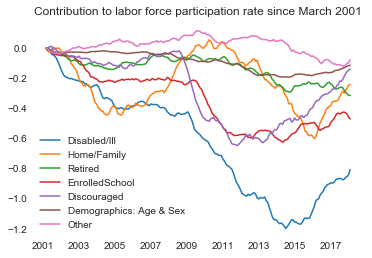

In [6]:
# Plot change since start date

# Add new values to list from earlier for full set of columns to plot
s2 = s + ['Demographics: Age & Sex', 'Other']
# Convert from nominal to share of population
df3 = df2[s2].div(df2['Population'], axis=0) * 100
# Calculate the difference from the base period
data2 = (df3.rolling(12).mean().loc[f'{base_period[0]}-{base_period[1]}-01']
         - df3.rolling(12).mean()).dropna()[3:]
# Plot the results
data2[s2].plot(title='Contribution to labor force participation rate since March 2001')